In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle as pk
from smt.sampling_methods import LHS
# from my_model import mymf
import sys
import os
import numpy as np
import matplotlib as mpl
import pickle as pk
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import shutil
from IPython.display import clear_output
from time import sleep
import h5py
# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
from flopy.utils.util_array import read1d
mpl.rcParams['figure.figsize'] = (8, 8)
from TCP3d_model import mymf
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

# annots = loadmat("/Volumes/GoogleDrive/My Drive/inverse_modeling/reactive_transport/kd.mat")
# annots.keys()

# kle = annots['kle_terms']
# K = annots['K']

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
numpy version: 1.19.2
matplotlib version: 3.3.1
flopy version: 3.3.2


In [ ]:
os.getcwd()

In [4]:
def simu(input_file):
    f = h5py.File(input_file, "r")
    kd = np.array(f["kd"])
    kd[kd<0] = 0
    kd = np.exp(kd)
    spd = np.array(f["welspd"])
    spd = {
        i:[
           tuple(
                [int(spd[i,0]), int(spd[i,1]), int(spd[i,2]),
                spd[i,3],
                int(spd[i,4])]
           )
        ]
        for i in range(len(spd))
    }
    f.close()
    my_model = mymf(dirname=input_file[-5]+'binary_files')
    ## run model
    conc, heads = my_model.run_model(kd, spd)
    
    f_out = h5py.File('../simu_outputs/output_' + input_file[6:], "w")
    f_out.create_dataset('concentration', data = conc, dtype ='f', compression = 'gzip')
    f_out.create_dataset('head', data = heads, dtype ='f', compression = 'gzip')
    f_out.close()
    my_model.plot_head(kd[3], title='conductivity field')
    my_model.simple_plot(conc[-1][3], title='conc')
    my_model.plot_head(heads, title='head')
    return conc, heads

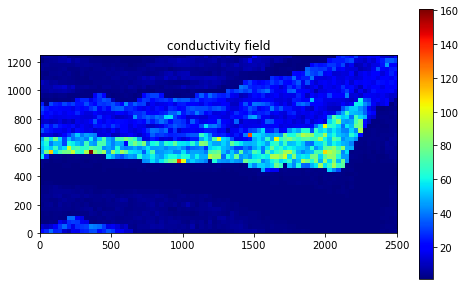

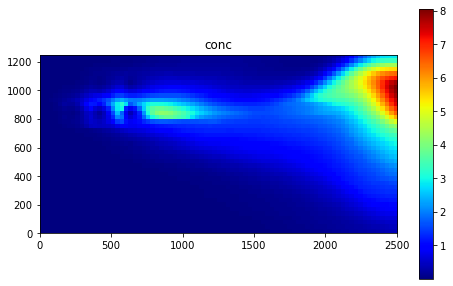

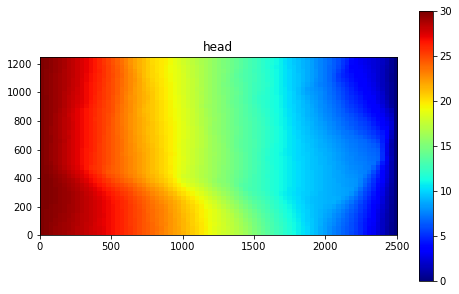

36.79973077774048


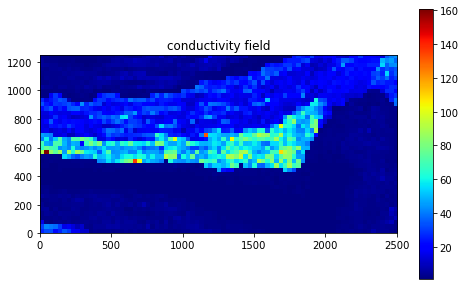

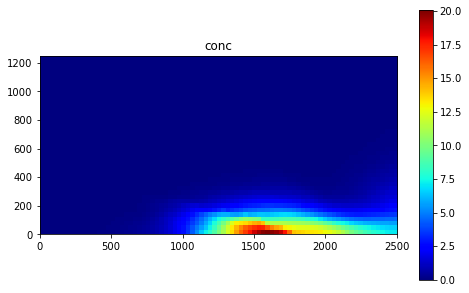

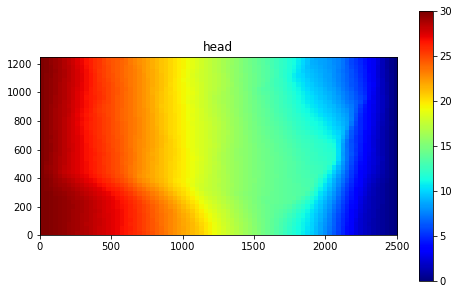

28.24548602104187


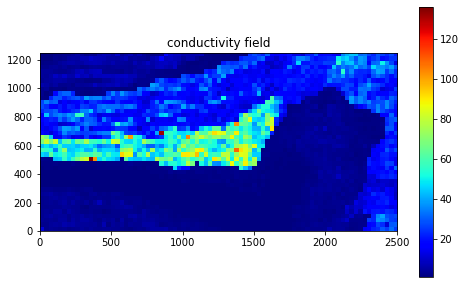

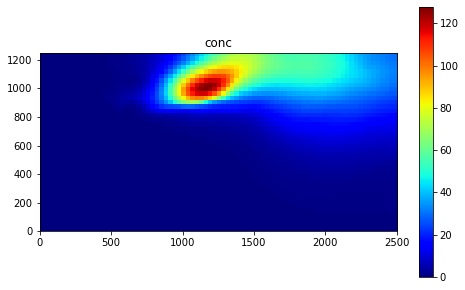

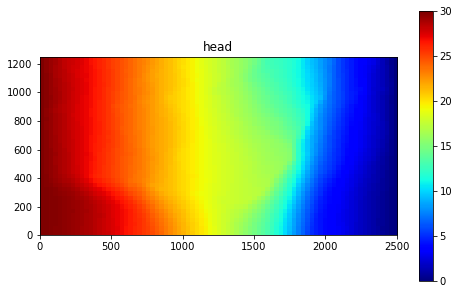

25.845850944519043


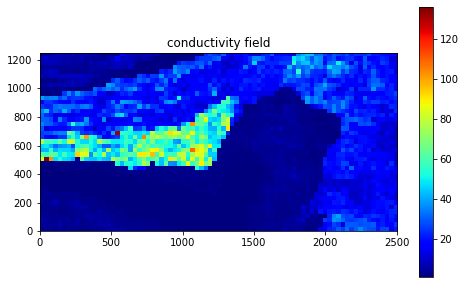

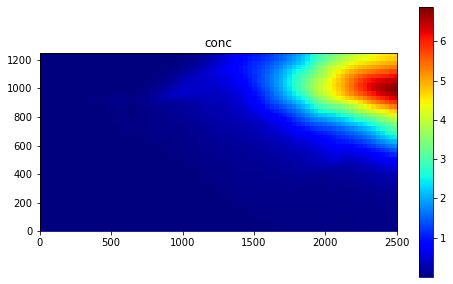

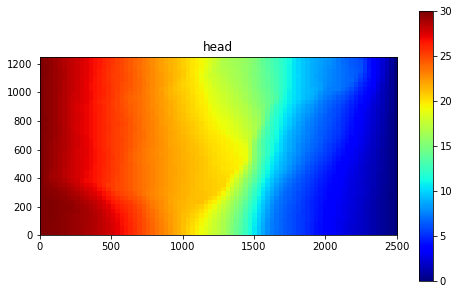

25.240639209747314


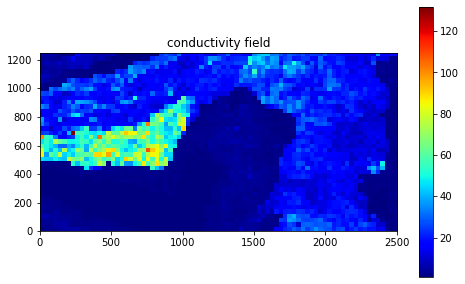

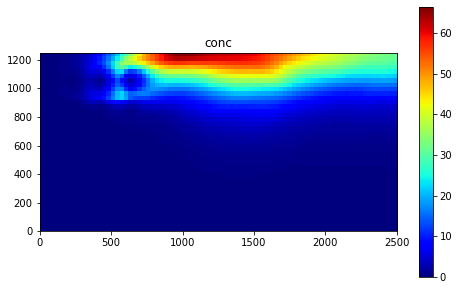

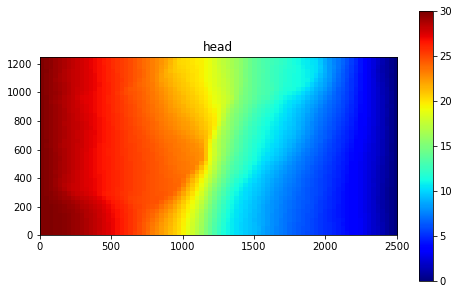

24.2375328540802


In [5]:
if __name__ == '__main__':
    exe_name_mf = '/Users/zitongzhou/Downloads/pymake/examples/mf2005'
    exe_name_mt = '/Users/zitongzhou/Downloads/pymake/examples/mt3dms'
    os.chdir('/Volumes/GoogleDrive/My Drive/react_inverse/simu_inputs/')
    for i in range(5):
        start = time.time()
        filename = 'input_'+str(i)+'.hdf5'
        conc, heads = simu(filename)
        print(time.time() - start)

In [ ]:
def well_plot(c_map, title,  wel = None, obs = None, ):
    nx = 81
    ny = 41
    Lx = 2500
    Ly = 1250
    dx = Lx/(nx-1)
    dy = Ly/(ny-1)


    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X,Y = np.meshgrid(x, y)
    fig, axs = plt.subplots(1,1)
#        axs.set_xlabel('x(m)')
#        axs.set_ylabel('y(m)')
    axs.set_xlim(0,Lx)
    axs.set_ylim(0,Ly)
    c01map = axs.imshow(c_map, cmap='jet',
              extent=[x.min(), x.max(), y.min(), y.max()],
              vmin=c_map.min(), vmax = c_map.max(),
              origin='lower')
    if wel:

        axs.scatter(wel["x"], wel["y"],  c = "blue", label='wells')
    
    if obs:
        
        axs.scatter(obs["x"], obs["y"], c = 'red', label = 'sensor')
        
#        CS = axs.contour(head, levels = np.arange(0, 10.5, 0.5), origin='lower', cmap='flag',
#                linewidths=2, extent=[x.min(), x.max(), y.min(), y.max()],)
    fig.colorbar(c01map, ax=axs,shrink=0.62)
    name = title + '.png'
    plt.title(title)
    plt.legend()
    fig.savefig('images/'+name, format='png',bbox_inches='tight')
    plt.show()
    return

In [ ]:
### wells and sensors
y_wel = np.array([6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34])# #np.random.randint(low = 5, high = 35, size = 20)
x_wel = np.array([1, 1, 1, 1, 1, 
         7, 7, 7, 7, 7,
         13, 13, 13, 13, 13,
         20, 20, 20, 20, 20])# #np.random.randint(low = 0, high = 25, size = 20)
wells = {i: [y_wel[i], x_wel[i]] for i in range(len(y_wel))}

np.random.seed(888)
y_obs = np.random.randint(low = 5, high = 35, size = 20)
x_obs = np.random.randint(low = 30, high = 80, size = 20)

hds = bf.HeadFile(os.path.join(my_model.model_ws, my_model.dirname + '_mf.hds'))
times = hds.get_times()  # simulation time, steady state
heads = hds.get_data(totim=times[-1])
hds.close()  # close the file object for the next run

head = heads[0]
head = np.flip(head, 0)
dx = 2500/80
dy = 1250/40

wel = {"x": list(dx/2 + x_wel*dx), "y": list(dy/2 + y_wel*dy)}
obs = {"x": list(dx/2 + x_obs*dx), "y": list(dy/2 + y_obs*dy)}
well_plot(head, 'Head_well',wel, obs)

## Release locations, concentrations

In [ ]:
N = 15000
local_state = np.random.RandomState(seed = None)

### x
np.random.seed(888)
y_wel = np.array([6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34])# #np.random.randint(low = 5, high = 35, size = 20)
x_wel = np.array([1, 1, 1, 1, 1, 
         7, 7, 7, 7, 7,
         13, 13, 13, 13, 13,
         20, 20, 20, 20, 20])# #np.random.randint(low = 0, high = 25, size = 20)
wells = {i: [3, y_wel[i], x_wel[i]] for i in range(len(y_wel))}

x_ind = np.random.choice(20, N)

x = [wells[x_ind[i]] for i in range(N)]

### q
q = 100*np.random.randint(low=1, high=15, size=(N, 5))

### make well stress period data:
mod_wels = {}
con_rate = {}
for mod in range(N):
    welspd = {}
    for i in range(5):
        welspd[i] = [3, x[mod][0], x[mod][1], q[mod, i], 2]
    welspd[5] = [3, x[mod][0], x[mod][1], 0, 2]
    mod_wels[mod] = welspd

## Parallel simulation

In [ ]:
f = h5py.File('input_1.hdf5', "r")
kd = np.exp(f["kd"])
spd = np.array(f["welspd"])
wel = {
    i:[
       tuple(
            [int(spd[i,0]), int(spd[i,1]), int(spd[i,2]),
            spd[i,3],
            int(spd[i,4])]
       )
    ]
    for i in range(len(spd))
}
f.close()
my_model = mymf(dirname='input_1.hdf5'[-5])
## run model
conc, heads = my_model.run_model(kd, spd)

In [ ]:
workdir = os.path.join('.',)

In [ ]:
os.path.join(workdir, 'work')

In [ ]:
if __name__ == '__main__':
    start = time.time()
    p = Pool(5)
    cache = p.map(throw_away_function, )
    print('parallel sampling time:',time.time() - start)
    with open('cache','wb') as file:
        pk.dump(cache,file)